# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [4]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [5]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Check TensorFlow version

In [6]:
tf.__version__

'2.4.1'

### Check TPU connection

In [ ]:
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

## Initial training

### Load custom modules

In [ ]:
try:
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure



In [ ]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = 'Ti_4_classes_linear_comb_small_gas_phase'

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = 'regression',
                            intensity_only = True)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Model folder created at /saved_models/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase
Logs folder created at /logs/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase
Figures folder created at /figures/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 1057 features (X) + 4 labels (y)


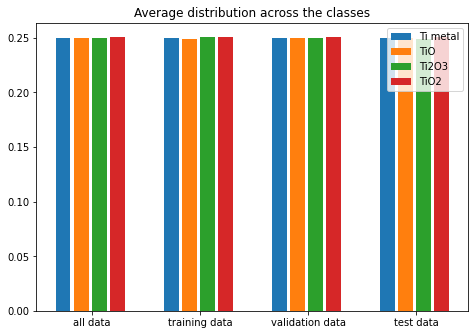

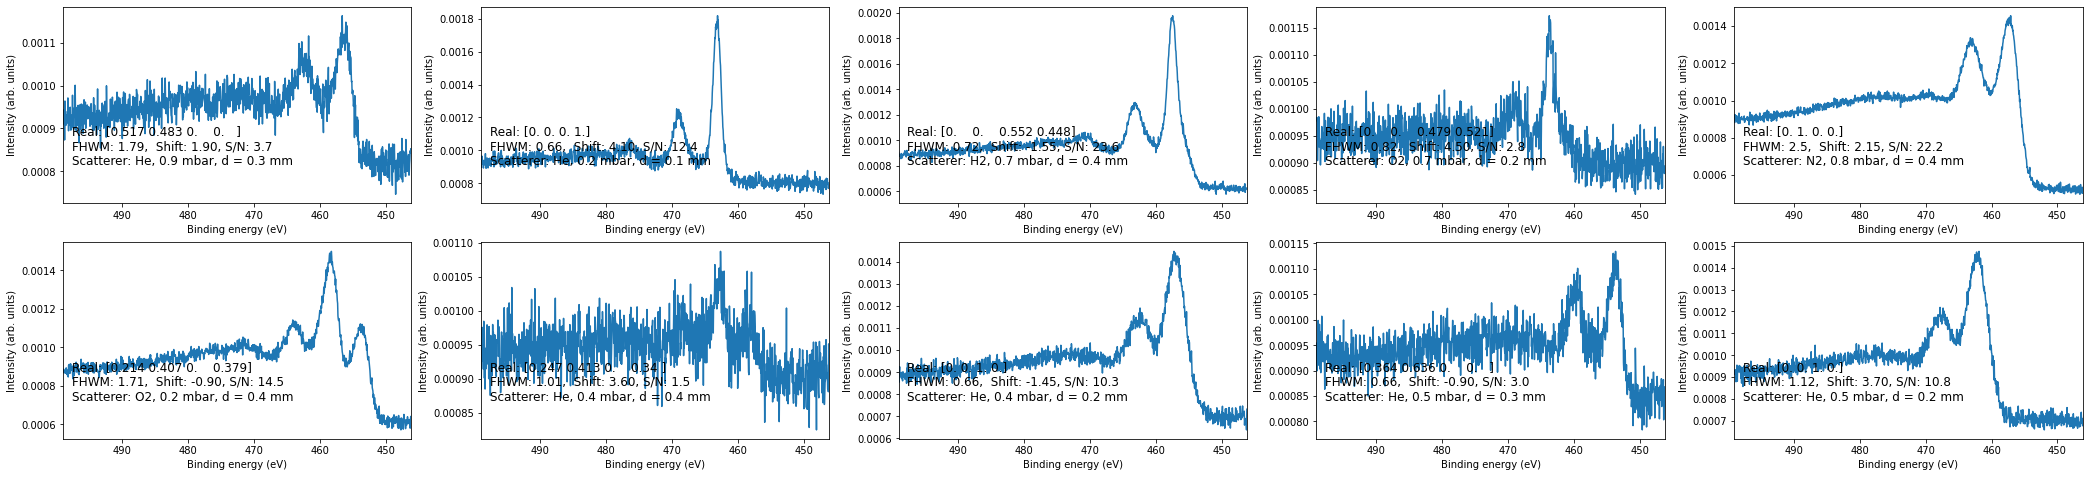

In [ ]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210318_Ti_linear_combination_small_gas_phase.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 200000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Design the model

In [ ]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

Models module was loaded.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class ResNet1D(models.EmptyModel):
    """
    Instantiates the ResNet50 architecture in 1D similar to the original 
    ResNet paper. Using the functional API in Keras.
    
    Implementation of the popular ResNet50 the following architecture:
    CONV1D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 ->
    CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> 
    IDBLOCK*2 -> AVGPOOL (optional) -> OUTPUTLAYER
    """
    def __init__(self,
                 inputshape,
                 num_classes,
                 ap=False,
                 no_of_inputs=1):
        """
        Parameters
        ----------
        num_classes : int
            Number of output classes.
        ap : bool, optional
            If ap, then an AveragePooling1D layer is added after the
            residual blocks. The default is False.
        no_of_inputs : int, optional
            Number of input layers. The default is 1.
            (not working here)

        Returns
        -------
        None.

        """
        self.ap = ap
        
        self.input_1 = layers.Input(shape=inputshape,
                                    name='input_1')
    
        # Zero-Padding
        self.zero_pad_1 = layers.ZeroPadding1D(padding=3)(self.input_1)
        
        # Stage 1
        self.conv_1 = layers.Conv1D(filters=64,
                                    kernel_size=2,
                                    padding='valid',
                                    kernel_initializer=glorot_uniform(seed=0),
                                    name='stage1_conv')(self.zero_pad_1)
        self.batch_1 = layers.BatchNormalization(
            axis=1,
            name='stage1_bn')(self.conv_1)
        self.act_1 = layers.Activation(
            activation='relu',
            name='stage1_act')(self.batch_1)
        self.max_pool_1 = layers.MaxPooling1D(
            pool_size=1,
            strides=1,
            name='stage1_max_pool')(self.act_1)
        
        # Stage 2
        self.conv_block_2a = models.ConvBlock(filters=[32,32,128],
                                       kernel_size_2=4,
                                       stage=2,
                                       block='a')(self.max_pool_1)
        self.id_block_2b = models.IdentityBlock(filters=[32,32,128],
                                         kernel_size_2=1,
                                         stage=2,
                                         block='b')(self.conv_block_2a)
        self.id_block_2c = models.IdentityBlock(filters=[32,32,128],
                                         kernel_size_2=1,
                                         stage=2,
                                         block='c')(self.id_block_2b)

        # Stage 3
        self.conv_block_3a = models.ConvBlock(filters=[64,64,256],
                                       kernel_size_2=3,
                                       stage=3,
                                       block='a')(self.id_block_2c)
        self.id_block_3b = models.IdentityBlock(filters=[64,64,256],
                                         kernel_size_2=3,
                                         stage=3,
                                         block='b')(self.conv_block_3a)
        self.id_block_3c = models.IdentityBlock(filters=[64,64,256],
                                         kernel_size_2=3,
                                         stage=3,
                                         block='c')(self.id_block_3b)
        self.id_block_3d = models.IdentityBlock(filters=[64,64,256],
                                         kernel_size_2=3,
                                         stage=3,
                                         block='d')(self.id_block_3c)
        
# =============================================================================
#         # Stage 4
#         self.conv_block_4a = models.ConvBlock(filters=[128,128,1024],
#                                        kernel_size_2=3,
#                                        stage=4,
#                                        block='a')(self.id_block_3d)
#         self.id_block_4b = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='b')(self.conv_block_4a)
#         self.id_block_4c = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                           block='c')(self.id_block_4b)
#         self.id_block_4d = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='d')(self.id_block_4c)
#         self.id_block_4e = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='e')(self.id_block_4d)
#         self.id_block_4f = models.IdentityBlock(filters=[128,128,1024],
#                                          kernel_size_2=3,
#                                          stage=4,
#                                          block='f')(self.id_block_4e)
# 
#         # Stage 5
#         self.conv_block_5a = models.ConvBlock(filters=[256,56,1024],
#                                        kernel_size_2=1,
#                                        stage=5,
#                                        block='a')(self.id_block_4f)
#         self.id_block_5b = models.IdentityBlock(filters=[256,56,1024],
#                                          kernel_size_2=1,
#                                          stage=5,
#                                          block='b')(self.conv_block_5a)
#         self.id_block_5c = models.IdentityBlock(filters=[256,56,1024],
#                                          kernel_size_2=1,
#                                          stage=5,
#                                          block='c')(self.id_block_5b)
# =============================================================================

        # Average pooling
        if self.ap:
            self.avg_pool = layers.AveragePooling1D(
                pool_size=3,
                name='avg_pool')(self.id_block_3d)
            self.flatten = layers.Flatten(name='flatten')(self.avg_pool)
        
        else:
            self.flatten = layers.Flatten(name='flatten')(self.id_block_3d)

        # output layer
        self.dense = layers.Dense(units=num_classes,
                                  activation='sigmoid',
                                  kernel_initializer = glorot_uniform(seed=0),
                                  name='dense')(self.flatten)
        
        # output norm
        self.output_norm = layers.Lambda(
            lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
            name = 'output_norm')(self.dense)
        
        super(ResNet1D, self).__init__(inputs=self.input_1,
                                        outputs=self.output_norm,
                                        inputshape=inputshape,
                                        num_classes=num_classes,
                                        no_of_inputs=no_of_inputs, 
                                        name ='ResNet1D')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class RegressionCNN(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    This is to be used for regression on all labels. -> sigmoid 
    activation in the last layer.
    """
    def __init__(self, inputshape, num_classes):      
        self.input_1 = layers.Input(shape = inputshape)
                


        self.conv_1_short = layers.Conv1D(filters=12,
                                          kernel_size=5,
                                          strides=1,
                                          padding='same',
                                          activation='relu',
                                          name='conv_1_short')(self.input_1)
        self.conv_1_medium = layers.Conv1D(filters=12,
                                           kernel_size=10,
                                           strides=1,
                                           padding='same',
                                           activation='relu',
                                           name='conv_1_medium')(self.input_1)
        self.conv_1_long = layers.Conv1D(filters=12,
                                         kernel_size=15,
                                         strides=1,
                                         padding='same',
                                         activation='relu',
                                         name='conv_1_long')(self.input_1)
        
        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = layers.Conv1D(filters=10,
                                    kernel_size=5,
                                    strides=1,
                                    padding='valid',
                                    activation='relu',
                                    name='conv_2')(merged_sublayers)
        self.conv_3 = layers.Conv1D(filters=10,
                                    kernel_size=5,
                                    strides=1,
                                    padding='valid',
                                    activation='relu',
                                    name="conv_3")(self.conv_2)
        self.average_pool_1 = layers.AveragePooling1D(
            name='average_pool_1')(self.conv_3)
        
        self.flatten_1 = layers.Flatten(name='flatten1')(self.average_pool_1)
        self.drop_1 = layers.Dropout(rate=0.2,
                                     name='drop_1')(self.flatten_1)
        self.dense_1 = layers.Dense(units=4000,
                                    activation='relu',
                                    name='dense_1')(self.drop_1)
        self.dense_2 = layers.Dense(units=num_classes,
                                    activation='sigmoid',
                                    name='dense_2')(self.dense_1)
        
        self.output_norm = layers.Lambda(
            lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
            name = 'output_normalization')(self.dense_2)

        no_of_inputs = len(sublayers)

        super(RegressionCNN, self).__init__(inputs=self.input_1,
                                            outputs=self.output_norm,
                                            inputshape=inputshape,
                                            num_classes=num_classes,
                                            no_of_inputs=no_of_inputs,
                                            name='RegressionCNN')

#### Build the model

In [ ]:
clf.model = RegressionCNN(clf.datahandler.input_shape,
                          clf.datahandler.num_classes)
# =============================================================================
# clf.model = ResNet1D(clf.datahandler.input_shape,
#                      clf.datahandler.num_classess,
#                      ap=True)
# =============================================================================

# Alternative: Build model from available models in models.py
# =============================================================================
# clf.model = models.RegressionCNN(clf.datahandler.input_shape, 
#                                  clf.datahandler.num_classes)
# =============================================================================
# =============================================================================
# clf.model = models.ResNet1D(clf.datahandler.input_shape,
#                             clf.datahandler.num_classess,
#                             ap=True)
# =============================================================================

### Compile and summarize the model

Model: "RegressionCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1057, 1)]    0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1D)           (None, 1057, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1D)          (None, 1057, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1D)            (None, 1057, 12)     192         input_1[0][0]                    
______________________________________________________________________________________

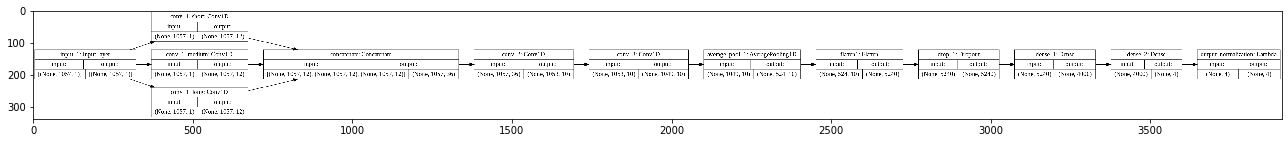

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.losses import CategoricalCrossentropy

learning_rate = 1e-05
optimizer = Adam(learning_rate = learning_rate) 

if clf.task == 'regression':
    mae = MeanAbsoluteError()
    clf.model.compile(loss = mae, optimizer = optimizer)
    # =============================================================================
    # mse = MeanSquaredError()
    # clf.model.compile(loss = mse, optimizer = optimizer)
    # =============================================================================
    
elif clf.task == 'classification':
    categorical_crossentropy = CategoricalCrossentropy()
    clf.model.compile(loss = categorical_crossentropy,
                      optimizer = optimizer,
                      metrics = ['accuracy'])

# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

1250/1250 [==============================] - 2s 2ms/step
Prediction done!
Train:
real: [1. 0. 0. 0.] pred: [0.25001216 0.24999149 0.2500115  0.24998488]
real: [0.157 0.    0.    0.843] pred: [0.25001177 0.24999397 0.25000918 0.24998511]
real: [0.    0.    0.311 0.689] pred: [0.25001365 0.24999139 0.25000918 0.24998575]
real: [0.    0.    0.431 0.569] pred: [0.25001162 0.24999127 0.25001076 0.24998632]
real: [0.377 0.    0.    0.623] pred: [0.25001293 0.24999103 0.2500099  0.24998611]
Test:
real: [1. 0. 0. 0.] pred: [0.2500127  0.24999037 0.25001255 0.24998441]
real: [0.357 0.145 0.    0.498] pred: [0.25001302 0.24999224 0.2500095  0.24998526]
real: [0.248 0.    0.396 0.355] pred: [0.25001252 0.24999106 0.25001192 0.24998453]
real: [0.    0.202 0.516 0.282] pred: [0.25001106 0.24999228 0.25001174 0.24998489]
real: [0.239 0.271 0.228 0.261] pred: [0.25001472 0.24999252 0.25000975 0.24998304]


### Train

In [ ]:
epochs = 1000
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

Epoch 1/1000
4000/4000 [==============================] - 34s 8ms/step - loss: 0.2245 - val_loss: 0.2208
Epoch 2/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.2186 - val_loss: 0.2134
Epoch 3/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.2129 - val_loss: 0.2089
Epoch 4/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.2075 - val_loss: 0.1955
Epoch 5/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.1919 - val_loss: 0.1682
Epoch 6/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.1685 - val_loss: 0.1505
Epoch 7/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.1533 - val_loss: 0.1371
Epoch 8/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.1404 - val_loss: 0.1267
Epoch 9/1000
4000/4000 [==============================] - 33s 8ms/step - loss: 0.1298 - val_loss: 0.1191
Epoch 10/1000
4000/4000 [==============================

### Plot loss

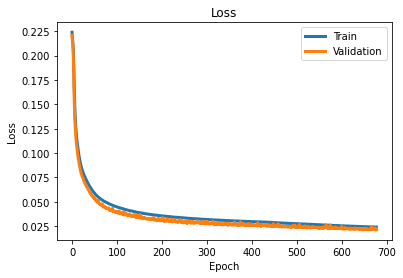

In [ ]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

1250/1250 [==============================] - 3s 2ms/step - loss: 0.0199
Evaluation done! 

Test loss: 0.01975744


###  Predict on train and test data

In [ ]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

1250/1250 [==============================] - 3s 2ms/step
Prediction done!


### Show some predictions

#### 10 random training samples

Calculating loss for each example...
Done!


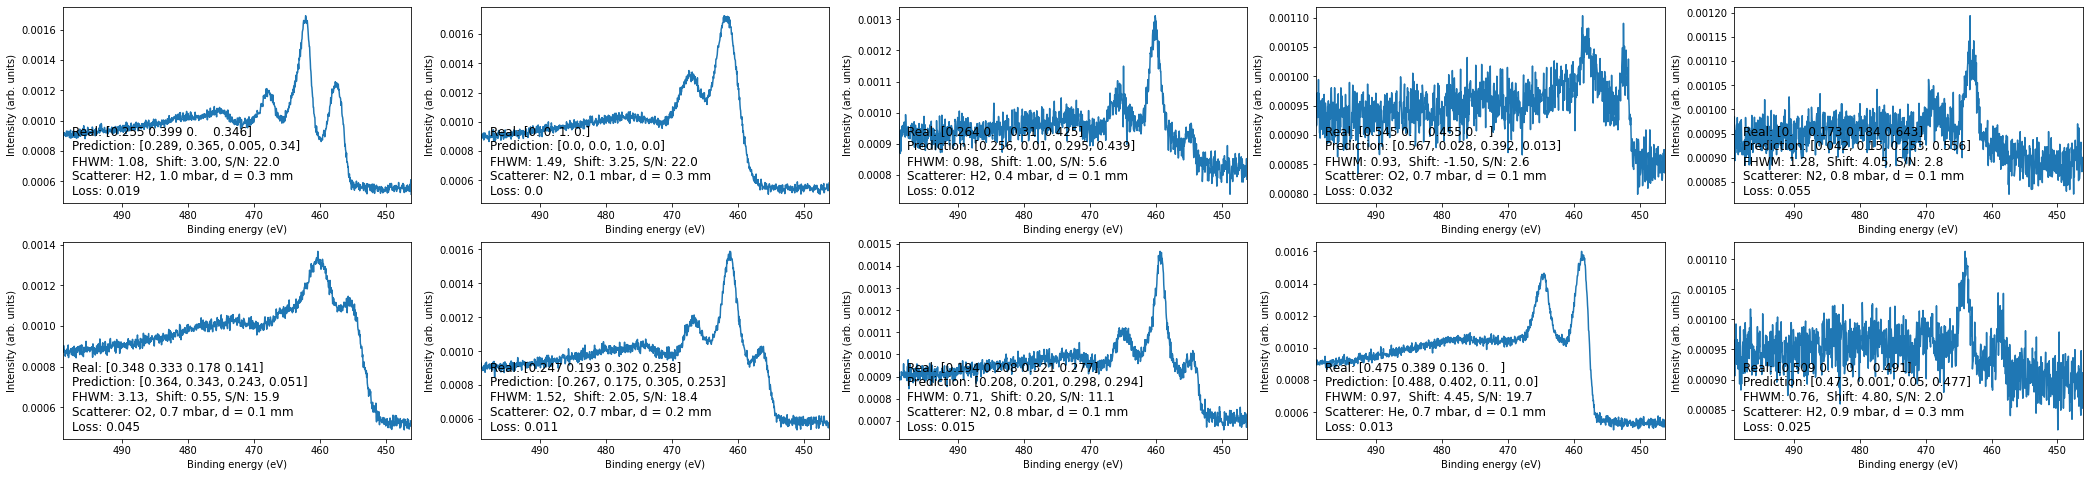

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

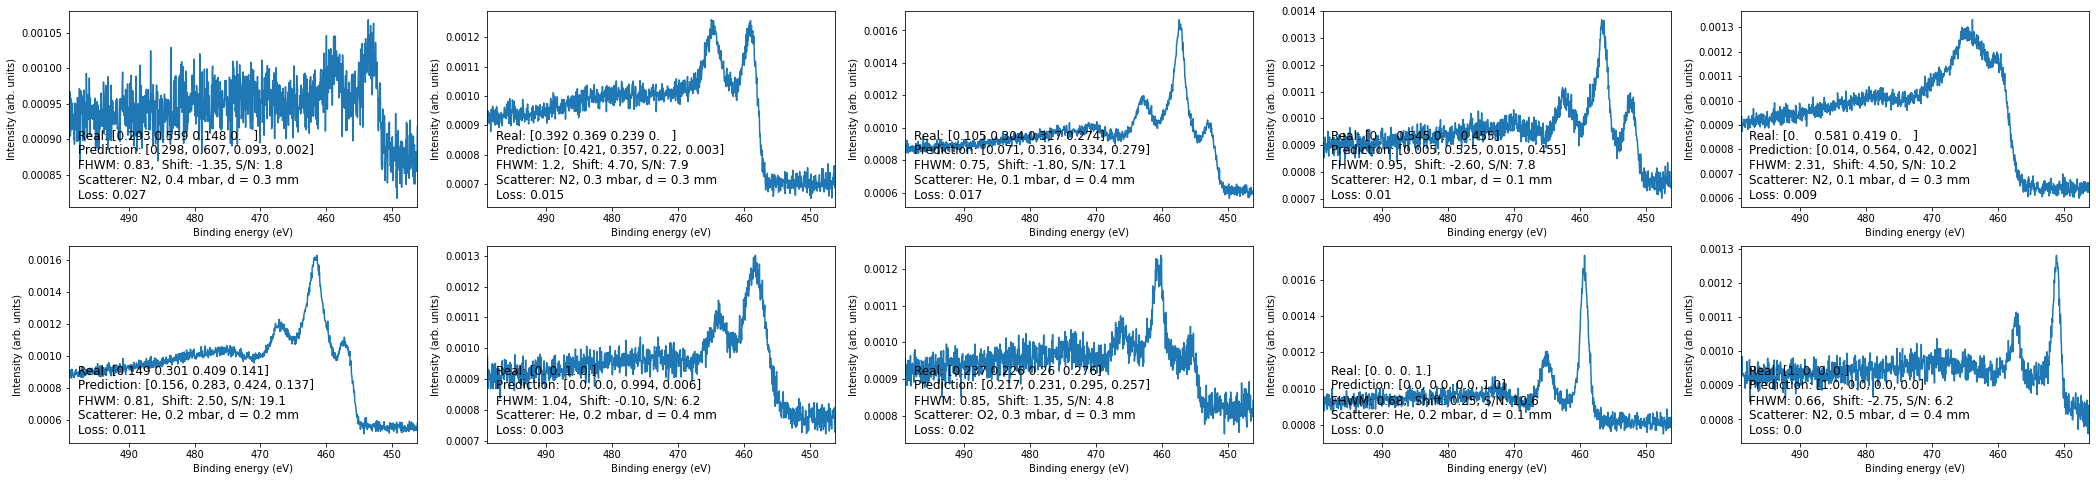

In [ ]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

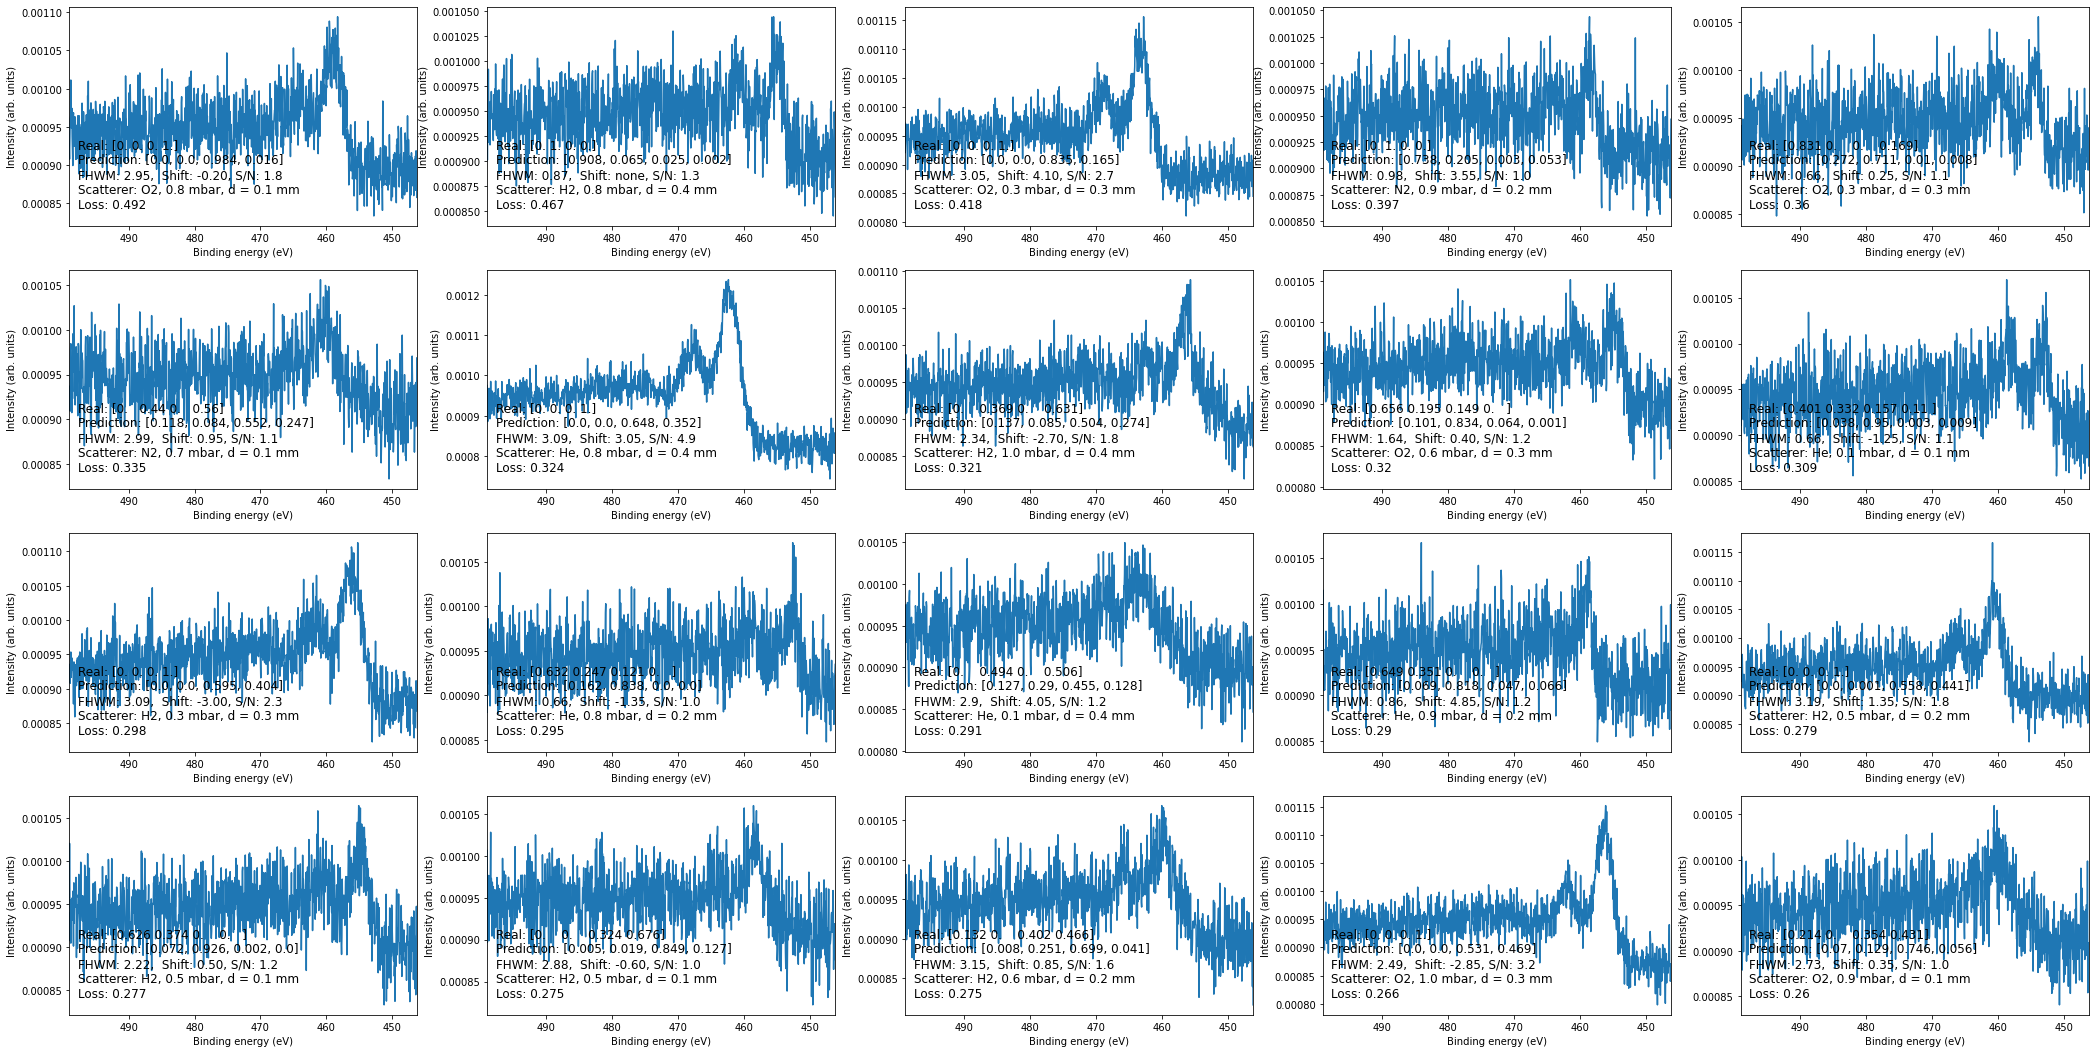

In [ ]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and results

In [ ]:
#clf.save_model()
clf.pickle_results()

Saved results to file.


### Generate report

In [ ]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

Report saved!


## Continue training

### Load custom modules

In [36]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('\n Modules were loaded.')

<module 'xpsdeeplearning.network.classifier' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/classifier.py'>

<module 'xpsdeeplearning.network.utils' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/utils.py'>


 Modules were reloaded.


### Reload classifier from logpath

In [37]:
logpath = r'/content/drive/My Drive/deepxps/logs/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase'
clf = classifier.restore_clf_from_logs(logpath)

Model folder was already at /saved_models/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase
Logs folder was already at /logs/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase
Figures folder was already at /figures/20210321_22h07m_Ti_4_classes_linear_comb_small_gas_phase
Recovered classifier from file.


### Load and inspect the data

Data was loaded!
Total no. of samples: 200000
No. of training samples: 128000
No. of validation samples: 32000
No. of test samples: 40000
Shape of each sample : 1057 features (X) + 4 labels (y)


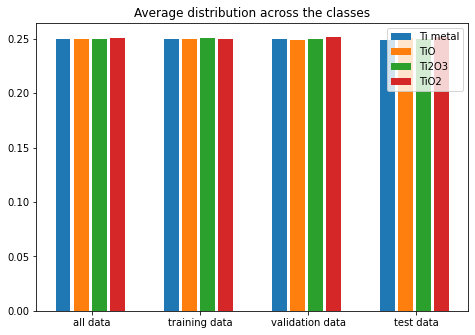

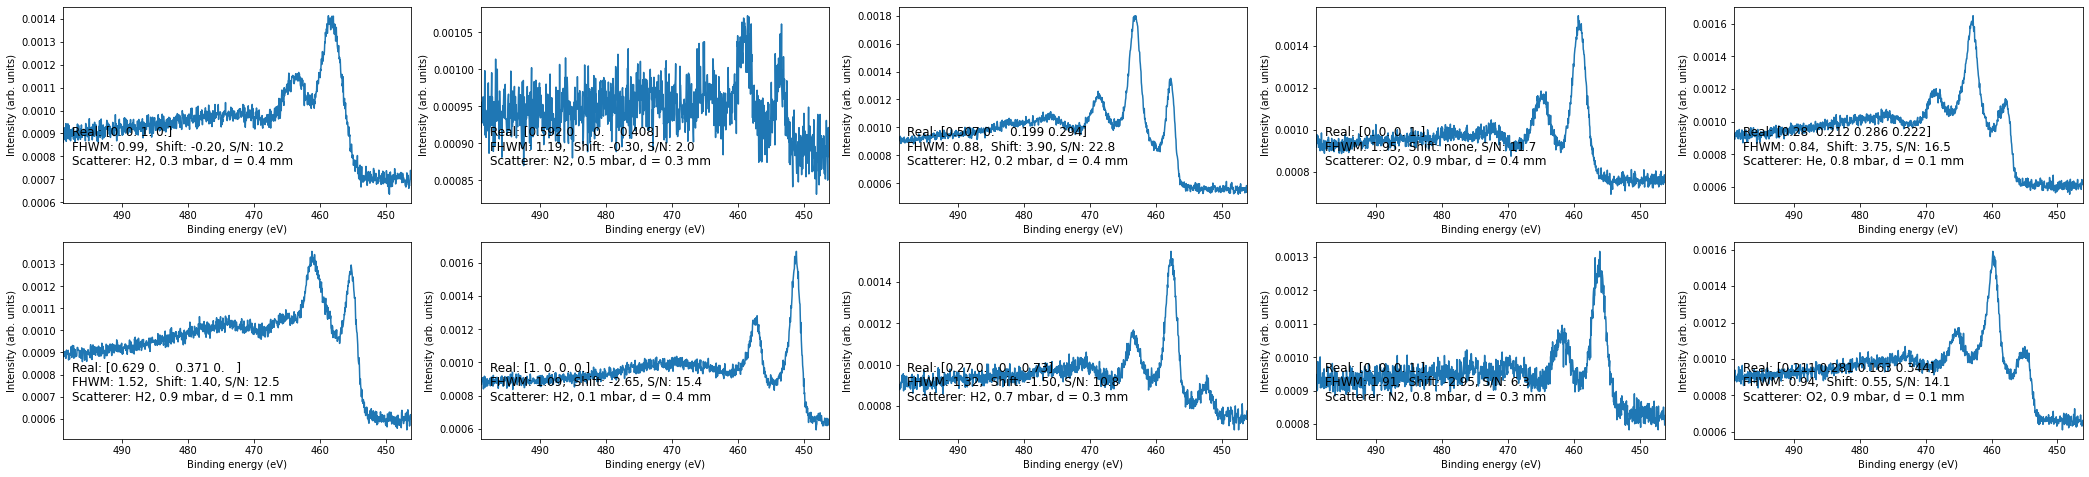

In [38]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        clf.load_data_preprocess(input_filepath = clf.logging.hyperparams['input_filepath'],
                                 no_of_examples = clf.logging.hyperparams['no_of_examples'],
                                 train_test_split = clf.logging.hyperparams['train_test_split'],
                                 train_val_split = clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [39]:
clf.load_model(compile_model = True)

Loaded model from disk.


### Summarize the model

Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1057, 1)]    0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1D)           (None, 1057, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1D)          (None, 1057, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1D)            (None, 1057, 12)     192         input_1[0][0]                    
_______________________________________________________________________________________

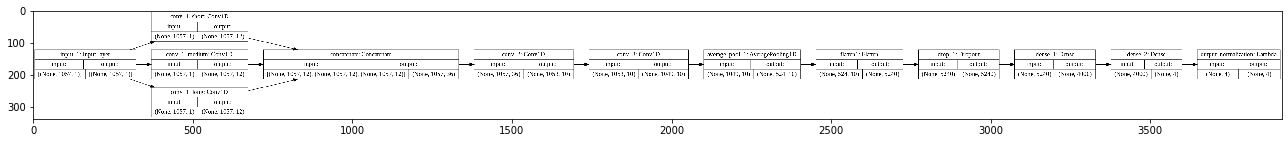

In [40]:
# Plot summary and save model plot.
clf.summary()
clf.save_and_print_model_image()

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

1250/1250 [==============================] - 3s 2ms/step
Prediction done!
Train:
real: [0.691 0.115 0.194 0.   ] pred: [0.7049483  0.0814086  0.20842789 0.00521523]
real: [0.    0.458 0.    0.542] pred: [0.00069528 0.47314703 0.00745367 0.51870406]
real: [0.   0.77 0.   0.23] pred: [6.8965816e-04 7.3787349e-01 6.5860279e-02 1.9557652e-01]
real: [0.213 0.525 0.    0.263] pred: [0.20961984 0.5130674  0.00728019 0.27003253]
real: [1. 0. 0. 0.] pred: [1.0000000e+00 6.7221329e-10 2.3541968e-10 6.7321833e-09]
Test:
real: [0.    0.    0.431 0.569] pred: [2.4817751e-07 9.2121818e-06 4.6048468e-01 5.3950584e-01]
real: [0. 1. 0. 0.] pred: [0.04509299 0.9468811  0.0066309  0.00139501]
real: [0.    0.    0.754 0.246] pred: [4.9850093e-11 6.3099554e-07 8.1609029e-01 1.8390913e-01]
real: [0. 1. 0. 0.] pred: [0.10622586 0.81470585 0.07564486 0.0034234 ]
real: [0.    0.    0.221 0.779] pred: [2.8314636e-05 1.0737979e-03 1.6217263e-01 8.3672529e-01]


### Train

In [ ]:
epochs = 500 #1000

new_learning_rate = 1e-05#5e-06

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

Epoch 679/1178
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0256 - val_loss: 0.0222
Epoch 680/1178
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0256 - val_loss: 0.0207
Epoch 681/1178
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0255 - val_loss: 0.0211
Epoch 682/1178
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0255 - val_loss: 0.0217
Epoch 683/1178
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0254 - val_loss: 0.0205
Epoch 684/1178
4000/4000 [==============================] - 26s 7ms/step - loss: 0.0254 - val_loss: 0.0207
Epoch 685/1178
4000/4000 [==============================] - 25s 6ms/step - loss: 0.0254 - val_loss: 0.0203
Epoch 686/1178
4000/4000 [==============================] - 27s 7ms/step - loss: 0.0254 - val_loss: 0.0213
Epoch 687/1178
4000/4000 [==============================] - 26s 6ms/step - loss: 0.0254 - val_loss: 0.0204
Epoch 688/1178
4000/4000 [===========

### Plot loss

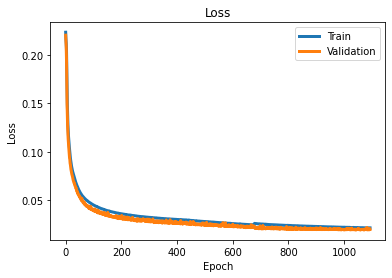

In [24]:
graph = clfutils.TrainingGraphs(clf.logging.history, clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if clf.task == 'classification':
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [41]:
if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

1250/1250 [==============================] - 108s 86ms/step - loss: 0.0169
Evaluation done! 

Test loss: 0.01681146


###  Predict on train and test data

In [42]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

1250/1250 [==============================] - 93s 75ms/step
Prediction done!


### Show some predictions

#### 10 random training samples

Calculating loss for each example...
Done!


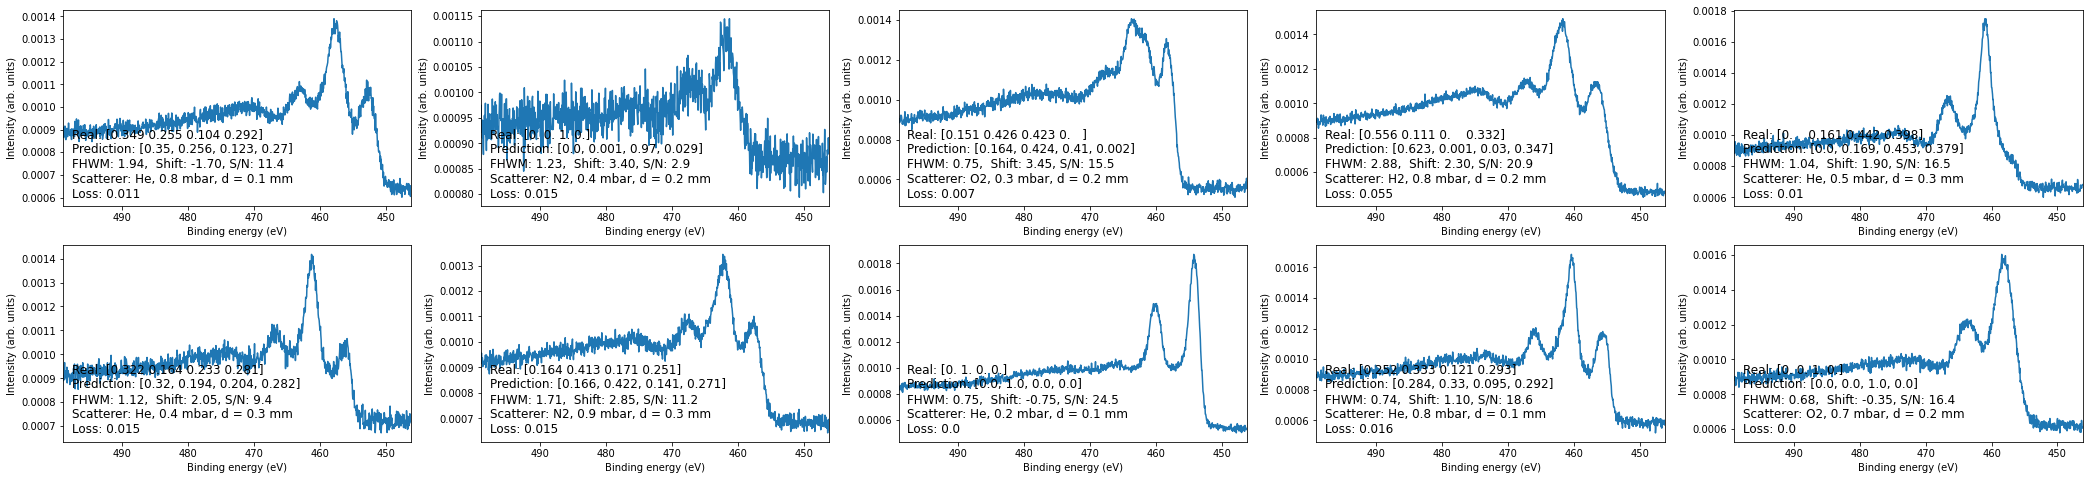

In [43]:
clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

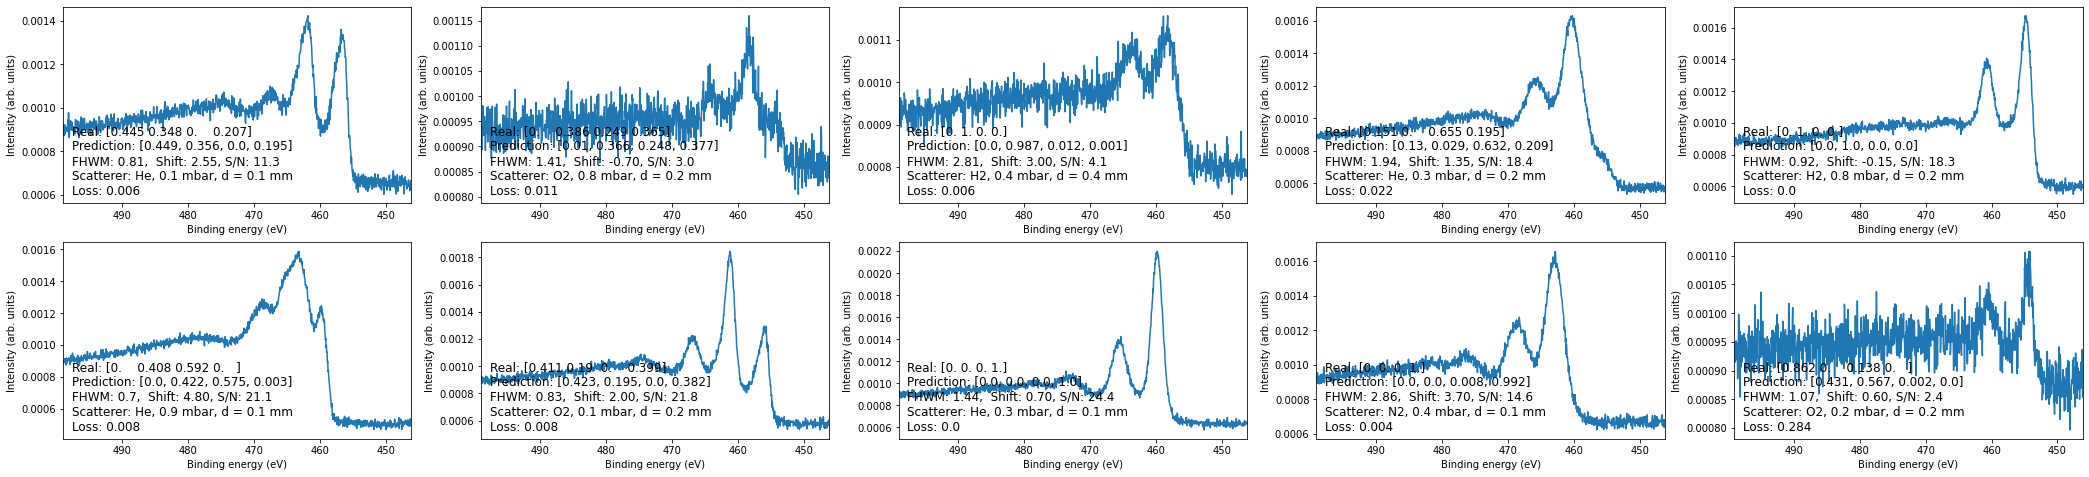

In [44]:
clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

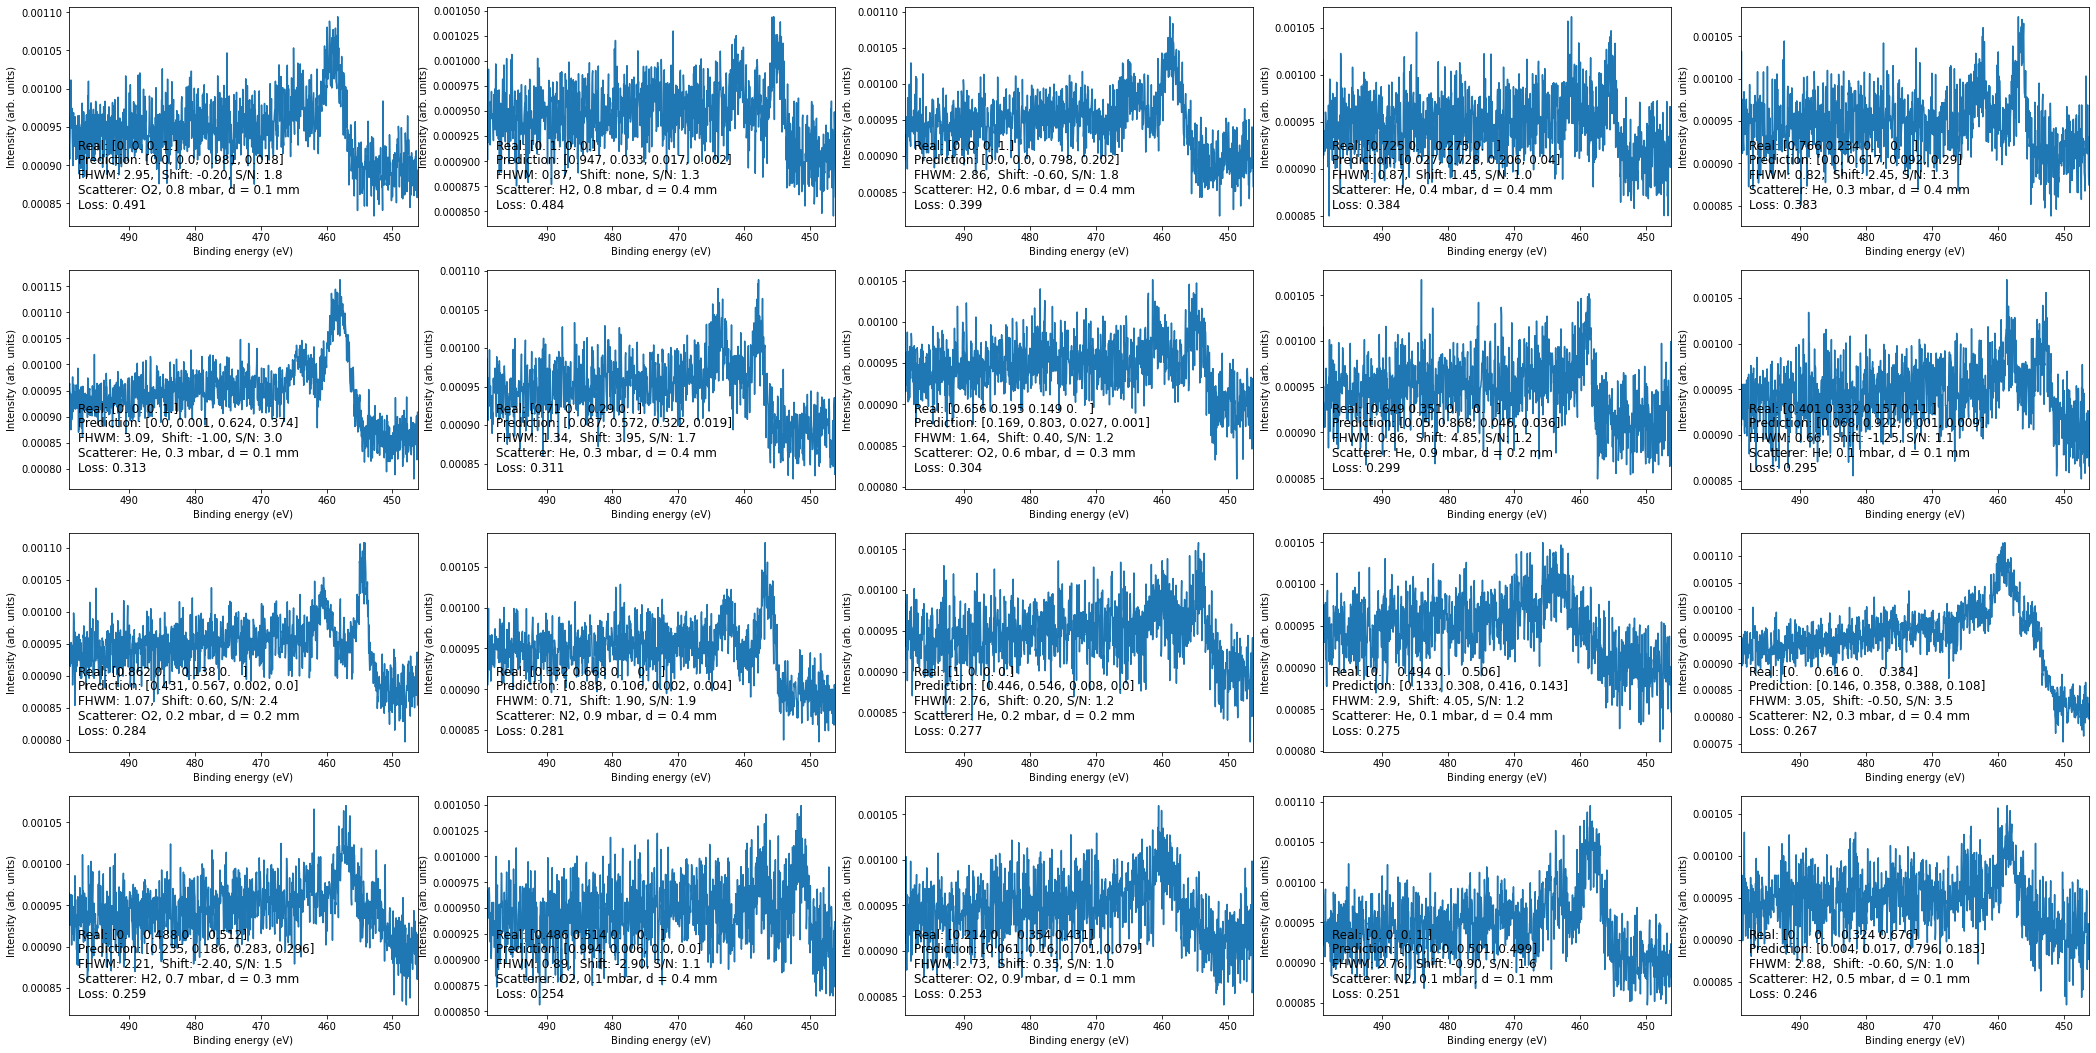

In [45]:
if clf.task == 'classification':
    clf.show_wrong_classification()
elif clf.task == 'regression':
    clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [46]:
#clf.save_model()
clf.pickle_results()

Saved results to file.


### Generate report

In [47]:
dir_name = clf.time + '_' + clf.exp_name
rep = clfutils.Report(dir_name)  
rep.write()

Report saved!


## Save output of notebook

In [48]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/train.ipynb'
output_file = os.path.join(clf.logging.log_dir,'train_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
